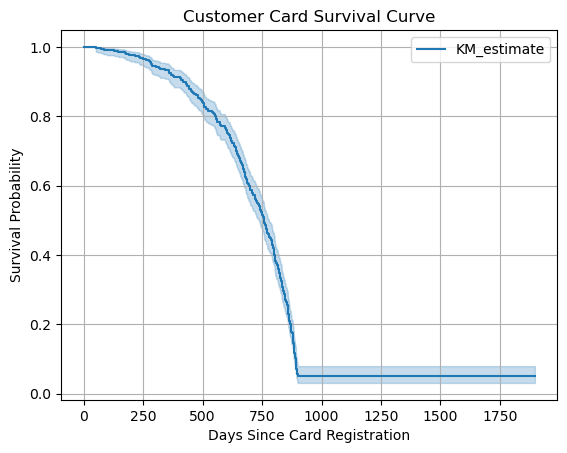

<lifelines.CoxPHFitter: fitted with 500 total observations, 66 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 500
number of events observed = 434
   partial log-likelihood = -2340.28
         time fit was run = 2025-04-26 14:54:15 UTC

---
                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                           
Age                 0.00      1.00      0.00           -0.01            0.01                0.99                1.01
Gender              0.07      1.07      0.10           -0.12            0.26                0.89                1.30
CardLeftoverAmount -0.00      1.00      0.00           -0.00            0.00                1.00                1.00

                    cmp to     z    p  -log2(p)
covariate                                      
Age                   0.00  0.06 0.96      0.07
Gender                0.00  0.74 0.46      1.12
CardLeftoverAmount    0.00 -1.33 0.18      2.44
---
Concordance = 0.51
Partial AIC = 4686.56
log-likelihood ratio test = 2.33 on 3 df
-log2(p) of ll-ratio test = 0.98

In [5]:
import pandas as pd
import numpy as np
import datetime
from faker import Faker
from lifelines import KaplanMeierFitter, CoxPHFitter
import matplotlib.pyplot as plt

# Initialize Faker
faker = Faker()
np.random.seed(42)

# Step 1: Generate DimCustomer
n_customers = 500
customers = []

for i in range(n_customers):
    customers.append({
        'CustomerKey': i + 1,
        'Name': faker.name(),
        'BirthDate': faker.date_of_birth(minimum_age=18, maximum_age=80),
        'Gender': np.random.choice(['Male', 'Female']),
        'Phone': faker.phone_number(),
        'Address': faker.address()
    })

customers = pd.DataFrame(customers)

# Step 2: Generate DimCards
cards = []
start_reg_date = datetime.date(2020, 1, 1)
end_reg_date = datetime.date(2023, 1, 1)

for i in range(n_customers):
    cards.append({
        'CardKey': i + 1,
        'CardCode': faker.bothify(text='????-####'),
        'RegistrationDate': faker.date_between(start_date=start_reg_date, end_date=end_reg_date),
        'CardLeftoverAmount': round(np.random.uniform(0, 500), 2)
    })

cards = pd.DataFrame(cards)

# Step 3: Generate FactTransactions
transactions = []

for cust_id in customers['CustomerKey']:
    n_trans = np.random.poisson(4)  # Average 4 transactions
    if n_trans == 0:
        continue
    reg_date = cards.loc[cards['CardKey'] == cust_id, 'RegistrationDate'].values[0]
    dates = pd.to_datetime(reg_date) + pd.to_timedelta(np.sort(np.random.randint(0, 900, size=n_trans)), unit='D')
    for d in dates:
        if d > pd.to_datetime('2025-04-26'):
            continue
        transactions.append({
            'CustomerKey': cust_id,
            'TransactionDate': d,
            'Amount': round(np.random.uniform(5, 300), 2)
        })

transactions = pd.DataFrame(transactions)

# Step 4: Prepare Survival Dataset
last_transaction = transactions.groupby('CustomerKey')['TransactionDate'].max().reset_index()
last_transaction.columns = ['CustomerKey', 'LastTransactionDate']

# Merge data
data = customers.merge(cards, left_on='CustomerKey', right_on='CardKey').merge(last_transaction, on='CustomerKey', how='left')

today = pd.to_datetime('2025-04-26')

# Calculate duration
data['duration'] = (data['LastTransactionDate'].fillna(today) - pd.to_datetime(data['RegistrationDate'])).dt.days
data['duration'] = data['duration'].clip(lower=1)  # Avoid zero duration

# Define event: churned if no transaction for > 180 days
data['event'] = np.where((today - data['LastTransactionDate']).dt.days > 180, 1, 0)
data['event'] = data['event'].fillna(1)  # no transactions at all

# Prepare variables for modeling
data['Age'] = (today - pd.to_datetime(data['BirthDate'])).dt.days // 365
data['Gender'] = data['Gender'].map({'Male': 0, 'Female': 1})

# Step 5: Kaplan-Meier Survival Curve
kmf = KaplanMeierFitter()
kmf.fit(data['duration'], event_observed=data['event'])

# Plot
kmf.plot_survival_function()
plt.title('Customer Card Survival Curve')
plt.xlabel('Days Since Card Registration')
plt.ylabel('Survival Probability')
plt.grid()
plt.show()

# Step 6: Cox Proportional Hazards Model
cph = CoxPHFitter()
cph.fit(data[['duration', 'event', 'Age', 'Gender', 'CardLeftoverAmount']], duration_col='duration', event_col='event')

# Summary
cph.print_summary()


In [1]:
pip install faker

Note: you may need to restart the kernel to use updated packages.
